loading config from /home/george-vengrovski/Documents/projects/Bird_JEPA/runs/MAE_3/model_config.json
[Encoder] 4.00M parameters
[Encoder] 4.00M parameters
Using Tp (time patches per chunk) = 256 for positional mean subtraction.
V1.pt: chunks=14, Fp=8, Tp=256, d=192, z_tok=torch.Size([3584, 1536]), spec_tok=(14, 128), lab_tok=(3584,)
V2.pt: chunks=19, Fp=8, Tp=256, d=192, z_tok=torch.Size([4864, 1536]), spec_tok=(19, 128), lab_tok=(4864,)
loaded 2 files → total tokens processed 8448
[raw] S (33, 128)   [enc] Z (8448, 1536)   labels (8448,)

Applying per-position mean subtraction using Tp = 256...
Per-position mean subtraction completed.

[UMAP-Original] fitting …

[UMAP-RoPE-Subtracted] fitting …


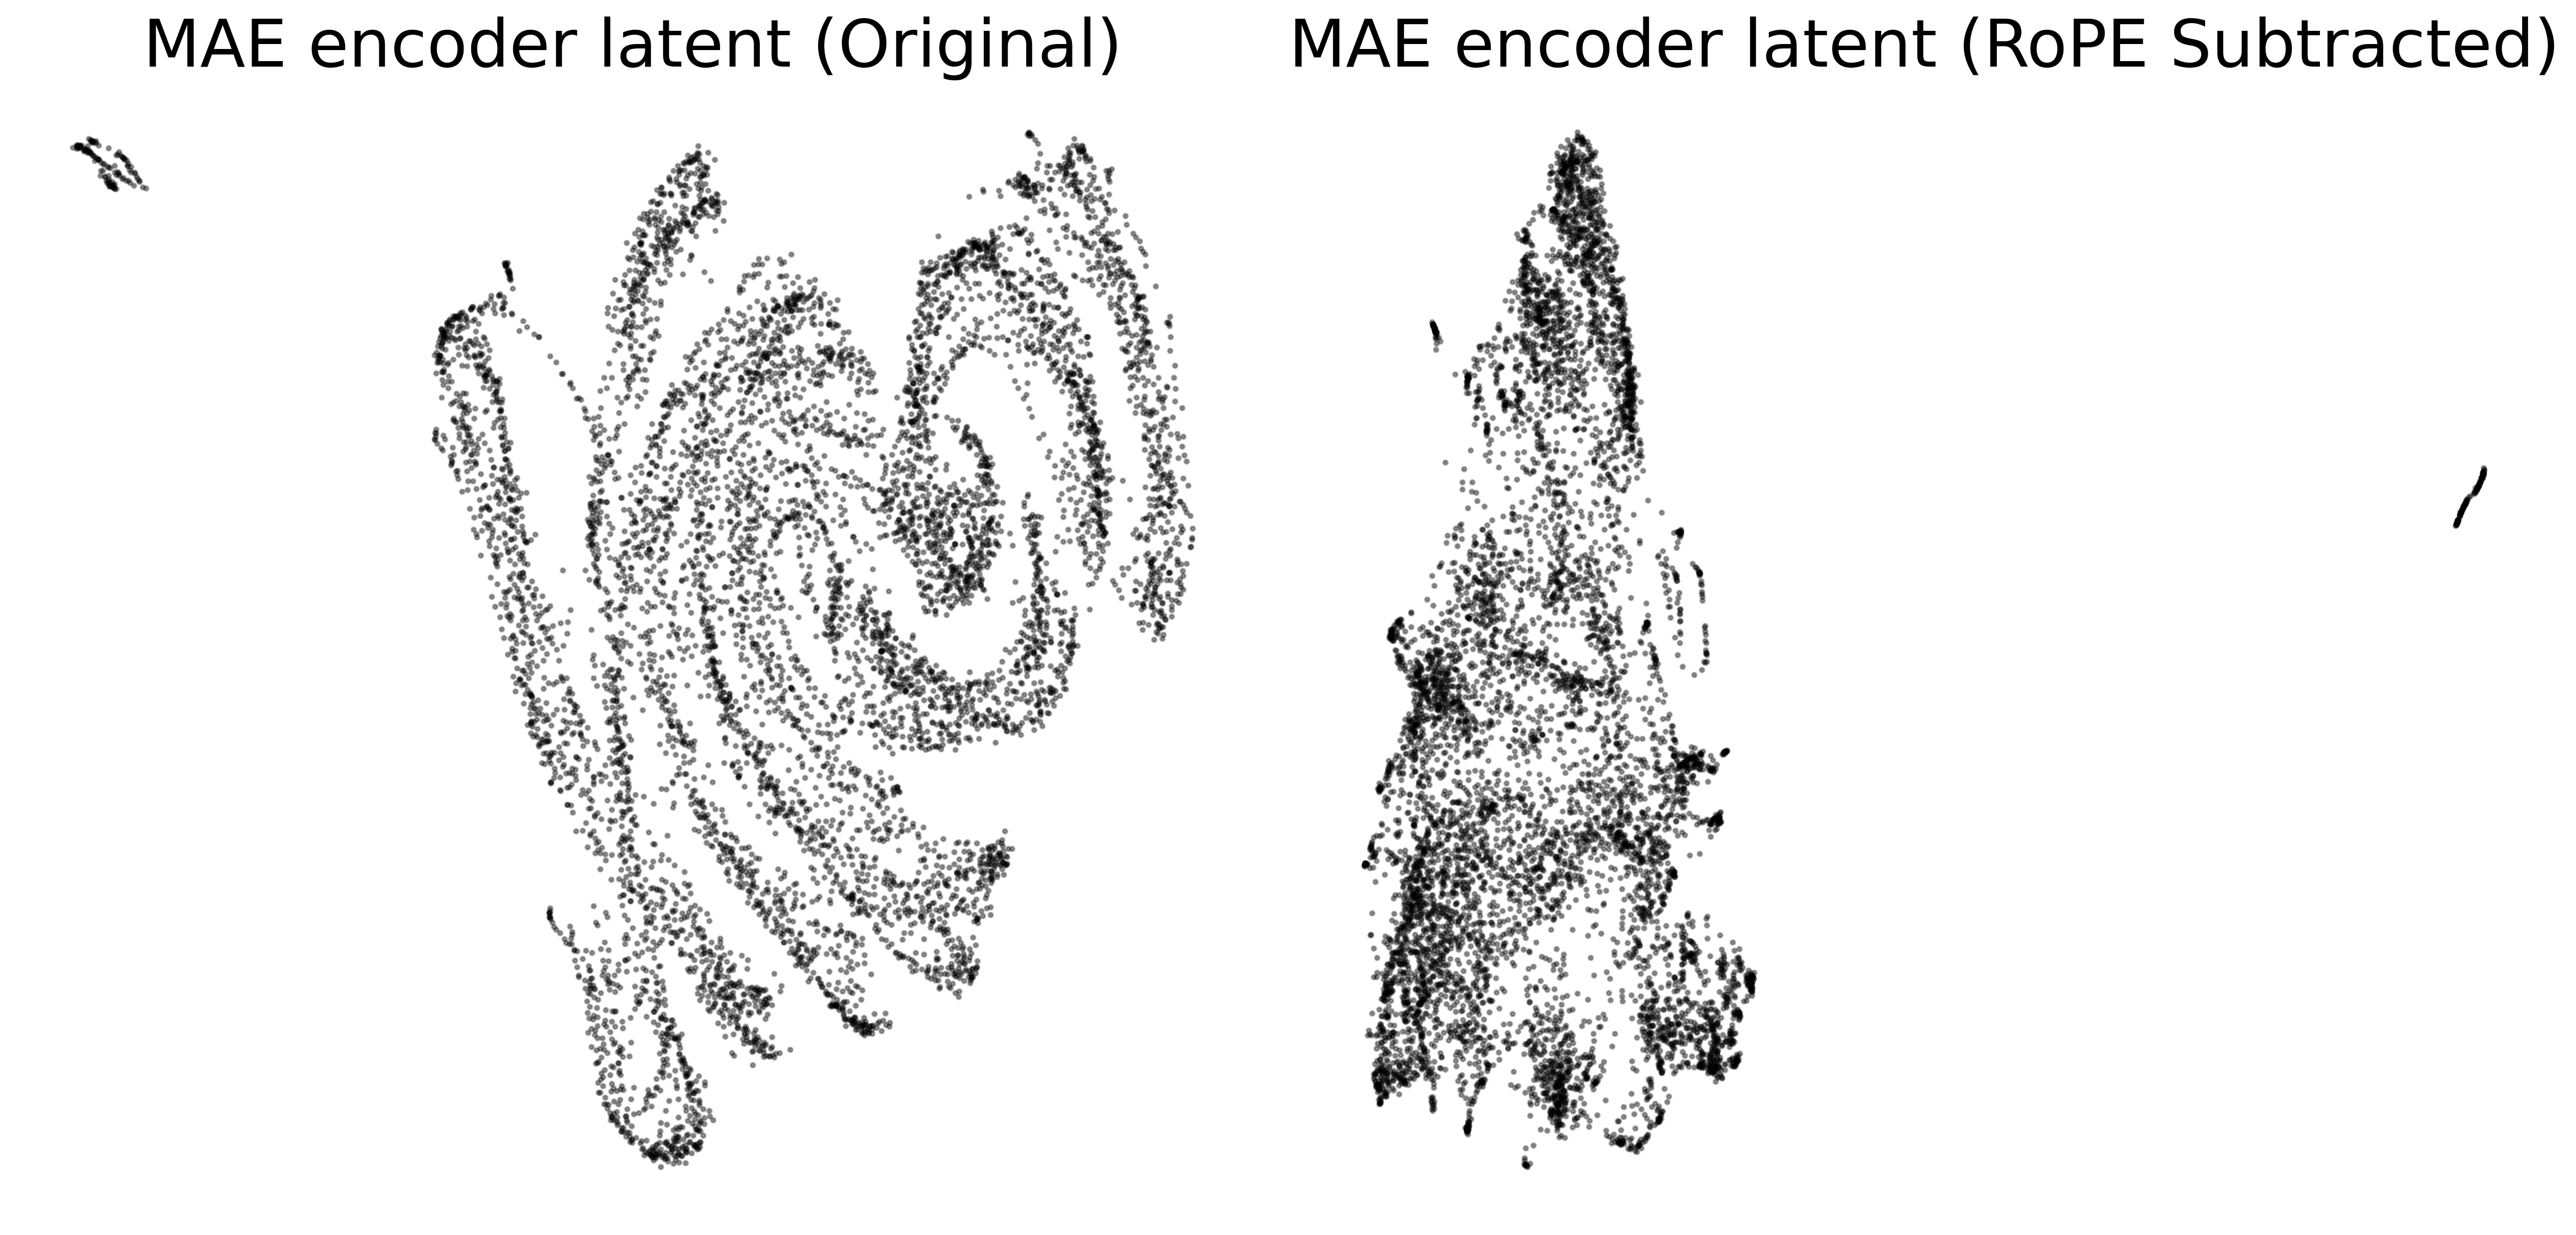

wrote human.png


/tmp/ipykernel_587357/2912422584.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


sanity-check figure saved to sanity_check_pos_subtracted.png


In [36]:
import argparse, glob, sys, os
from pathlib import Path
import json # Needed to load config

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set matplotlib font size globally to be 2x bigger
plt.rcParams.update({'font.size': 24})  # Default is usually 12, so 24 is 2x

# ──────────────────────────────────────────────────────────────────────
# repo import
here = Path(os.getcwd()).resolve()  # Get current working directory instead of __file__
repo_root = here.parent                 # Bird_JEPA/
sys.path.insert(0, str(repo_root / "src"))
from models.birdjepa import BirdJEPA, BJConfig            # noqa: E402

try:
    import umap                     # pip install umap-learn
except ImportError:
    sys.exit("UMAP not found – pip install umap-learn and retry.")

# Add PCA import
from sklearn.decomposition import PCA


def make_cmap(n_cls=73):
    """create a discrete color palette for up to `n_cls` classes."""
    base = (plt.get_cmap("tab20").colors +
            plt.get_cmap("tab20b").colors +
            plt.get_cmap("tab20c").colors)
    repeats = (n_cls + len(base) - 1) // len(base)
    return ListedColormap((base * repeats)[:n_cls])

def load_encoder_and_config(ckpt_path: Path, device):
    """
    load a BirdJEPA encoder from checkpoint and its corresponding config.
    """
    if not ckpt_path.exists():
        raise FileNotFoundError(f"no weights at {ckpt_path}")

    state = torch.load(ckpt_path, map_location="cpu")
    state = state.get("enc", state.get("model", state))
    if "model" in state:
        state = {k[len("encoder."):]: v for k, v in state.items() if k.startswith("encoder.")}

    config_path = ckpt_path.parent / "model_config.json"
    # Also check parent directory of weights folder
    config_path_parent = ckpt_path.parent.parent / "model_config.json"
    
    if not config_path.exists() and config_path_parent.exists():
        config_path = config_path_parent
    
    if not config_path.exists():
        if 'args' in state and state['args'] is not None:
            print("loading config from checkpoint args...")
            cfg_dict = state['args']
            cfg_dict['layers'] = cfg_dict.get('encoder_layers', cfg_dict.get('layers', 8))
            cfg_dict['n_heads'] = cfg_dict.get('encoder_n_heads', cfg_dict.get('n_heads', 6))
            cfg_dict['ff_mult'] = cfg_dict.get('encoder_ff_mult', cfg_dict.get('ff_mult', 4))
            cfg = BJConfig(**{k: v for k, v in cfg_dict.items() if hasattr(BJConfig, k)})
        else:
            raise FileNotFoundError(f"model_config.json not found at {config_path} and no args in checkpoint")
    else:
        print(f"loading config from {config_path}")
        with open(config_path, 'r') as f:
            cfg_dict = json.load(f)
        cfg = BJConfig(**cfg_dict)

    enc = BirdJEPA(cfg).to(device)
    enc.load_state_dict(state, strict=False)
    enc.eval()
    total_params = sum(p.numel() for p in enc.parameters()) / 1e6
    print(f"[Encoder] {total_params:.2f}M parameters")
    return enc, cfg

def spec_tokens_chunked(spec_z: torch.Tensor, chunk_indices: range, context_length: int) -> np.ndarray:
    """
    average spectrogram frames within each chunk for simplicity.
    returns shape (N_chunks, F).
    """
    F, T = spec_z.shape
    all_s_tok = []
    for start_idx in chunk_indices:
        end_idx = min(start_idx + context_length, T)
        chunk = spec_z[:, start_idx:end_idx]
        if chunk.numel() > 0:
            all_s_tok.append(chunk.mean(dim=1))
        else:
            all_s_tok.append(torch.zeros(F))
    s_tok_chunk_avg = torch.stack(all_s_tok).numpy()
    print(f"warning: spec_tokens_chunked returning chunk averages ({s_tok_chunk_avg.shape}), may not perfectly align with z_tok")
    return s_tok_chunk_avg

def labels_chunked(labels: torch.Tensor, chunk_indices: range, context_length: int, Tp_per_chunk: int) -> np.ndarray:
    """
    extract label at each time-center token for each chunk.
    returns shape (N_chunks * Tp_per_chunk,).
    """
    T_full = labels.shape[0]
    all_lab_tok = []
    time_centers_per_chunk = np.linspace(0, context_length - 1, Tp_per_chunk, dtype=int)
    for start_idx in chunk_indices:
        chunk_center_indices = start_idx + time_centers_per_chunk
        chunk_center_indices = np.clip(chunk_center_indices, 0, T_full - 1)
        all_lab_tok.append(labels[chunk_center_indices])
    return torch.cat(all_lab_tok).numpy()

@torch.no_grad()

def encode_clip_chunked(pt_path: Path, enc: BirdJEPA, context_length: int, device):
    """
    encode a spectrogram `.pt` file in fixed-size chunks using the BirdJEPA encoder.
    returns:
      - z_tok: (total_Tp_effective, Fp * d)
      - spec_tok: (N_chunks, F)
      - lab_tok: (total_Tp_effective,)
      - mag_ft: (Fp, Tp) magnitude grid from first chunk
      - spec_z: (F, T_full) full z-scored spectrogram (as numpy)
    """
    d = torch.load(pt_path, map_location="cpu")
    spec_raw = d["s"].float()            # (F, T_full)
    spec_z = (spec_raw - spec_raw.mean()) / (spec_raw.std() + 1e-6)
    labels = d["labels"].long()          # (T_full,)
    F, T_full = spec_z.shape

    all_z_flat = []
    chunk_indices = range(0, T_full, context_length)

    for i, start_idx in enumerate(chunk_indices):
        end_idx = start_idx + context_length
        chunk = spec_z[:, start_idx:end_idx]
        _, T_chunk = chunk.shape

        if T_chunk < context_length:
            padding = context_length - T_chunk
            chunk = torch.nn.functional.pad(chunk, (0, padding), mode='constant', value=0)

        # model forward expects shape (B, C, F, T)
        z_flat_chunk, Fp_model, Tp_model = enc(chunk[None, None].to(device))
        z_flat_chunk = z_flat_chunk.squeeze(0).cpu()  # (Fp * Tp, d)
        all_z_flat.append(z_flat_chunk)

        if i == 0:
            Fp = Fp_model
            Tp = Tp_model
            d_h = z_flat_chunk.shape[-1]
            mag_ft = z_flat_chunk.view(Fp, Tp, d_h).norm(dim=-1).numpy()

    z_flat_all = torch.cat(all_z_flat, dim=0)  # (N_chunks * Fp * Tp, d)
    total_Tp_effective = len(chunk_indices) * Tp
    # reshape to (total_Tp_effective, Fp * d)
    z_flat_chunks_reshaped = z_flat_all.view(len(chunk_indices), Fp * Tp, d_h)
    z_tok = (
        z_flat_chunks_reshaped
        .view(len(chunk_indices), Fp, Tp, d_h)
        .permute(0, 2, 1, 3)
        .reshape(total_Tp_effective, Fp, d_h)
        .reshape(total_Tp_effective, Fp * d_h)
    )

    spec_tok = spec_tokens_chunked(spec_z, chunk_indices, context_length)  # (N_chunks, F)
    lab_tok = labels_chunked(labels, chunk_indices, context_length, Tp)     # (total_Tp_effective,)

    print(f"{pt_path.name}: chunks={len(chunk_indices)}, Fp={Fp}, Tp={Tp}, d={d_h}, "
          f"z_tok={z_tok.shape}, spec_tok={spec_tok.shape}, lab_tok={lab_tok.shape}")
    return z_tok, spec_tok, lab_tok, mag_ft, spec_z.numpy()

def sanity_grid(rows, out_png="sanity_check.png"):
    """
    plot side-by-side: full spectrogram and |z| grid for up to 10 clips.
    `rows` should be a list of tuples: (name, spec_z, pc1).
    """
    n = len(rows)
    if n == 1:
        fig, ax = plt.subplots(1, 2, figsize=(10, 2.2), dpi=120,
                               gridspec_kw=dict(wspace=.02, hspace=.3))
        ax = ax.reshape(1, -1)  # Make it 2D for consistent indexing
    else:
        fig, ax = plt.subplots(n, 2, figsize=(10, 2.2 * n), dpi=120,
                               gridspec_kw=dict(wspace=.02, hspace=.3))
    vmin = min(r[2].min() for r in rows)
    vmax = max(r[2].max() for r in rows)

    for i, (name, spec_z, pc1) in enumerate(rows):
        ax[i, 0].imshow(spec_z, aspect="auto", origin="lower", cmap="magma")
        ax[i, 0].set_title(name, fontsize=16)
        ax[i, 0].axis("off")

        im = ax[i, 1].imshow(pc1, aspect="auto", origin="lower",
                             cmap="viridis", vmin=vmin, vmax=vmax)
        ax[i, 1].axis("off")

    cb = fig.colorbar(im, ax=ax[:, 1].tolist(), fraction=.025, pad=.01, aspect=30)
    cb.set_label("token PC-1")
    plt.tight_layout()
    plt.savefig(out_png, bbox_inches="tight")
    plt.close(fig)
    print(f"sanity-check figure saved to {out_png}")


spec_dir = "/media/george-vengrovski/Desk SSD/BirdJEPA/human"  # directory containing `.pt` files
ckpt_path = "/home/george-vengrovski/Documents/projects/Bird_JEPA/runs/MAE_3/weights/best.pt"  # path to BirdJEPA encoder checkpoint
out_png = "human.png"  # output filename for the UMAP plot
max_tokens = 256_000  # maximum number of tokens to process
device = "cpu"
include_zero_labels = True  # Set to True to include files with all zero labels

device = torch.device(device)

# 4.1. Load encoder and config
encoder, cfg = load_encoder_and_config(Path(ckpt_path), device)
# Get Tp (number of time-patches per chunk) from the loaded encoder
# This Tp is used by RoPE internally and for reshaping z_tok
Tp_val = encoder.Tp
print(f"Using Tp (time patches per chunk) = {Tp_val} for positional mean subtraction.")

# 4.2. Find `.pt` files
pt_files = sorted(glob.glob(os.path.join(spec_dir, "*.pt")))
if not pt_files:
    raise FileNotFoundError("no `.pt` files found in spec_dir")

token_budget = max_tokens
tokens_so_far = 0

Z_list, S_list, L_list = [], [], []
sanity_rows = []

for fp in pt_files:
    if tokens_so_far >= token_budget:
        break

    context_len = cfg.context_length
    z_tok, s_tok, lab_tok, mag_ft, spec_z = encode_clip_chunked(Path(fp), encoder, context_len, device)

    if not include_zero_labels and (lab_tok.size == 0 or lab_tok.max() == 0):
        print(f"skipping {Path(fp).name} due to empty or all-zero labels.")
        continue

    num_tokens_in_clip = z_tok.shape[0]
    keep = min(token_budget - tokens_so_far, num_tokens_in_clip)

    # align dimensions: z_tok: (total_Tp_effective, Fp*d)
    # s_tok: (N_chunks, F) will generally have fewer rows than z_tok; here we use chunk-level spec features
    Z_list.append(z_tok[:keep])
    S_list.append(s_tok[:min(keep, s_tok.shape[0])])
    L_list.append(lab_tok[:keep])
    tokens_so_far += keep

    if len(sanity_rows) < 10:
        # For sanity: take PC-1 of the first chunk
        pc1 = mag_ft  # magnitude grid from first chunk
        sanity_rows.append((Path(fp).stem, spec_z, pc1))

print(f"loaded {len(Z_list)} files → total tokens processed {tokens_so_far}")

Z = np.concatenate(Z_list, 0)
S = np.concatenate(S_list, 0)
L = np.concatenate(L_list, 0)

print(f"[raw] S {S.shape}   [enc] Z {Z.shape}   labels {L.shape}")

# Keep original Z for comparison
Z_original = np.array(Z, copy=True)

# --- New: Subtract average direction for each position in the sequence ---
if Z.shape[0] > 0 and Tp_val > 0:
    print(f"\nApplying per-position mean subtraction using Tp = {Tp_val}...")
    Z_modified = np.array(Z, copy=True) # Work on a copy
    num_total_tokens = Z_modified.shape[0]

    for p in range(Tp_val):
        # Create indices for all tokens that are at position 'p' within their respective chunks
        # The z_tok structure is [chunk1_t0, ..., chunk1_t(Tp-1), chunk2_t0, ...],
        # so tokens at position 'p' will be at global indices p, p+Tp, p+2*Tp, ...
        indices_at_pos_p = np.arange(p, num_total_tokens, Tp_val)
        
        if indices_at_pos_p.size > 0:
            tokens_at_this_position = Z_modified[indices_at_pos_p]
            mean_vec_at_pos_p = np.mean(tokens_at_this_position, axis=0)
            Z_modified[indices_at_pos_p] = tokens_at_this_position - mean_vec_at_pos_p
            # print(f"  Subtracted mean for position {p} (from {indices_at_pos_p.size} tokens)")
        else:
            print(f"  No tokens found for position {p} to subtract mean from.")
    
    print("Per-position mean subtraction completed.")
else:
    print("\nSkipping per-position mean subtraction (Z is empty or Tp_val is invalid).")
    Z_modified = Z_original

# Fit UMAP for both original and position-mean-subtracted embeddings
reducer_original = umap.UMAP(n_components=2, metric='cosine', n_jobs=-1, low_memory=True, n_neighbors=100, min_dist=0.1)
print("\n[UMAP-Original] fitting …")
emb_original = reducer_original.fit_transform(Z_original)

reducer_rope_subtracted = umap.UMAP(n_components=2, metric='cosine', n_jobs=-1, low_memory=True, n_neighbors=100, min_dist=0.1)
print("\n[UMAP-RoPE-Subtracted] fitting …")
emb_rope_subtracted = reducer_rope_subtracted.fit_transform(Z_modified)

# 5.2. Scatter Plot Helper
def scatter_plot(ax, emb, lab, title):
    bg = lab == 0
    fg = ~bg
    lab_fg = lab[fg]
    if bg.any():
        ax.scatter(emb[bg, 0], emb[bg, 1], c="black", s=3, alpha=.35, label='background (0)')
    if fg.any():
        lab_fg_adjusted = lab_fg - 1 if lab_fg.min() > 0 else lab_fg
        max_label_val = lab.max() if lab.size > 0 else 0
        ax.scatter(emb[fg, 0], emb[fg, 1], c=lab_fg_adjusted, s=3, alpha=.7,
                   cmap=make_cmap(max_label_val if max_label_val > 0 else 1))
    ax.set_title(title)
    ax.axis("off")

# 5.3. Create Figure and Plot both UMAPs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
scatter_plot(ax1, emb_original, L, "MAE encoder latent (Original)")
scatter_plot(ax2, emb_rope_subtracted, L, "MAE encoder latent (RoPE Subtracted)")
plt.tight_layout()
plt.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"wrote {out_png}")

# %% [markdown]
# ### 6. Sanity Check Visualization (Optional)

# %%
if sanity_rows:
    sanity_grid(sanity_rows, out_png="sanity_check_pos_subtracted.png")
